In [3]:
from bayesian_linear import BayesLinear
from negative_elbo import NegativeELBO
import torch
import numpy as np
import torch.nn.functional as F
from bayesian_linear import BayesLinear
from negative_elbo import NegativeELBO
import torch.utils.data as Data
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [22]:
# Bayesian Neural Network
class BayesNN(torch.nn.Module):
    def __init__(self, prior_std_init=0.05):
        super(BayesNN, self).__init__()
        self.bl1 = BayesLinear(1, 200, prior_std_init=prior_std_init)
        self.bl2 = BayesLinear(200, 100, prior_std_init=prior_std_init)
        self.bl3 = BayesLinear(100, 1, prior_std_init=prior_std_init)
        
        self.ble = BayesLinear(200, 200, prior_std_init=prior_std_init)

    def forward(self, x):
        x = F.leaky_relu(self.bl1(x))
        x = F.leaky_relu(self.ble(x))
        x = F.leaky_relu(self.bl2(x))
        x = self.bl3(x)
        return x
    
    def get_stds(self):
        stds = []
        for name, param in list(net.named_parameters()):
            if 'std' in name: 
                stds += list(param.detach().numpy().reshape(-1,))
        return stds


In [13]:
# Build data sets
def get_dset1():
    x1 = np.linspace(-3, -1, 20)
    y1 = np.ones_like(x1)
    x2 = np.linspace(-1, 1, 30)
    y2 = np.zeros_like(x2)
    x3 = np.linspace(1, 3, 20)
    y3 = np.ones_like(x3)

    X = torch.Tensor(np.concatenate([x1, x2, x3])).reshape(-1, 1)
    Y = torch.Tensor(np.concatenate([y1, y2, y3]))
    return X, Y


def get_dset2():
    x1 = np.linspace(-3, -1, 20)
    y1 = 2* np.ones_like(x1)
    x2 = np.linspace(-1, 0, 20)
    y2 = -2*x2
    x3 = np.linspace(0, 1, 20)
    y3 = 2*x3
    x4 = np.linspace(1, 3, 20)
    y4 = 2*np.ones_like(x4)

    X = torch.Tensor(np.concatenate([x1, x2, x3, x4])).reshape(-1, 1)
    Y = torch.Tensor(np.concatenate([y1, y2, y3, y4]))
    return X, Y

def get_dset3():
    x1 = np.linspace(-3, -1, 20)
    y1 = 2* np.ones_like(x1)
    # x2 = np.linspace(-1, 0, 20)
    # y2 = -2*x2
    # x3 = np.linspace(0, 1, 20)
    # y3 = 2*x3
    x4 = np.linspace(1, 3, 20)
    y4 = 2*np.ones_like(x4)

    X = torch.Tensor(np.concatenate([x1, x4])).reshape(-1, 1)
    Y = torch.Tensor(np.concatenate([y1, y4]))
    return X, Y

Finished epoch Nr.  0 / 100
Finished epoch Nr.  1 / 100
Finished epoch Nr.  2 / 100
Finished epoch Nr.  3 / 100
Finished epoch Nr.  4 / 100
Finished epoch Nr.  5 / 100
Finished epoch Nr.  6 / 100
Finished epoch Nr.  7 / 100
Finished epoch Nr.  8 / 100
Finished epoch Nr.  9 / 100
Finished epoch Nr.  10 / 100
Finished epoch Nr.  11 / 100
Finished epoch Nr.  12 / 100
Finished epoch Nr.  13 / 100
Finished epoch Nr.  14 / 100
Finished epoch Nr.  15 / 100
Finished epoch Nr.  16 / 100
Finished epoch Nr.  17 / 100
Finished epoch Nr.  18 / 100
Finished epoch Nr.  19 / 100
Finished epoch Nr.  20 / 100
Finished epoch Nr.  21 / 100
Finished epoch Nr.  22 / 100
Finished epoch Nr.  23 / 100
Finished epoch Nr.  24 / 100
Finished epoch Nr.  25 / 100
Finished epoch Nr.  26 / 100
Finished epoch Nr.  27 / 100
Finished epoch Nr.  28 / 100
Finished epoch Nr.  29 / 100
Finished epoch Nr.  30 / 100
Finished epoch Nr.  31 / 100
Finished epoch Nr.  32 / 100
Finished epoch Nr.  33 / 100
Finished epoch Nr.  34 /

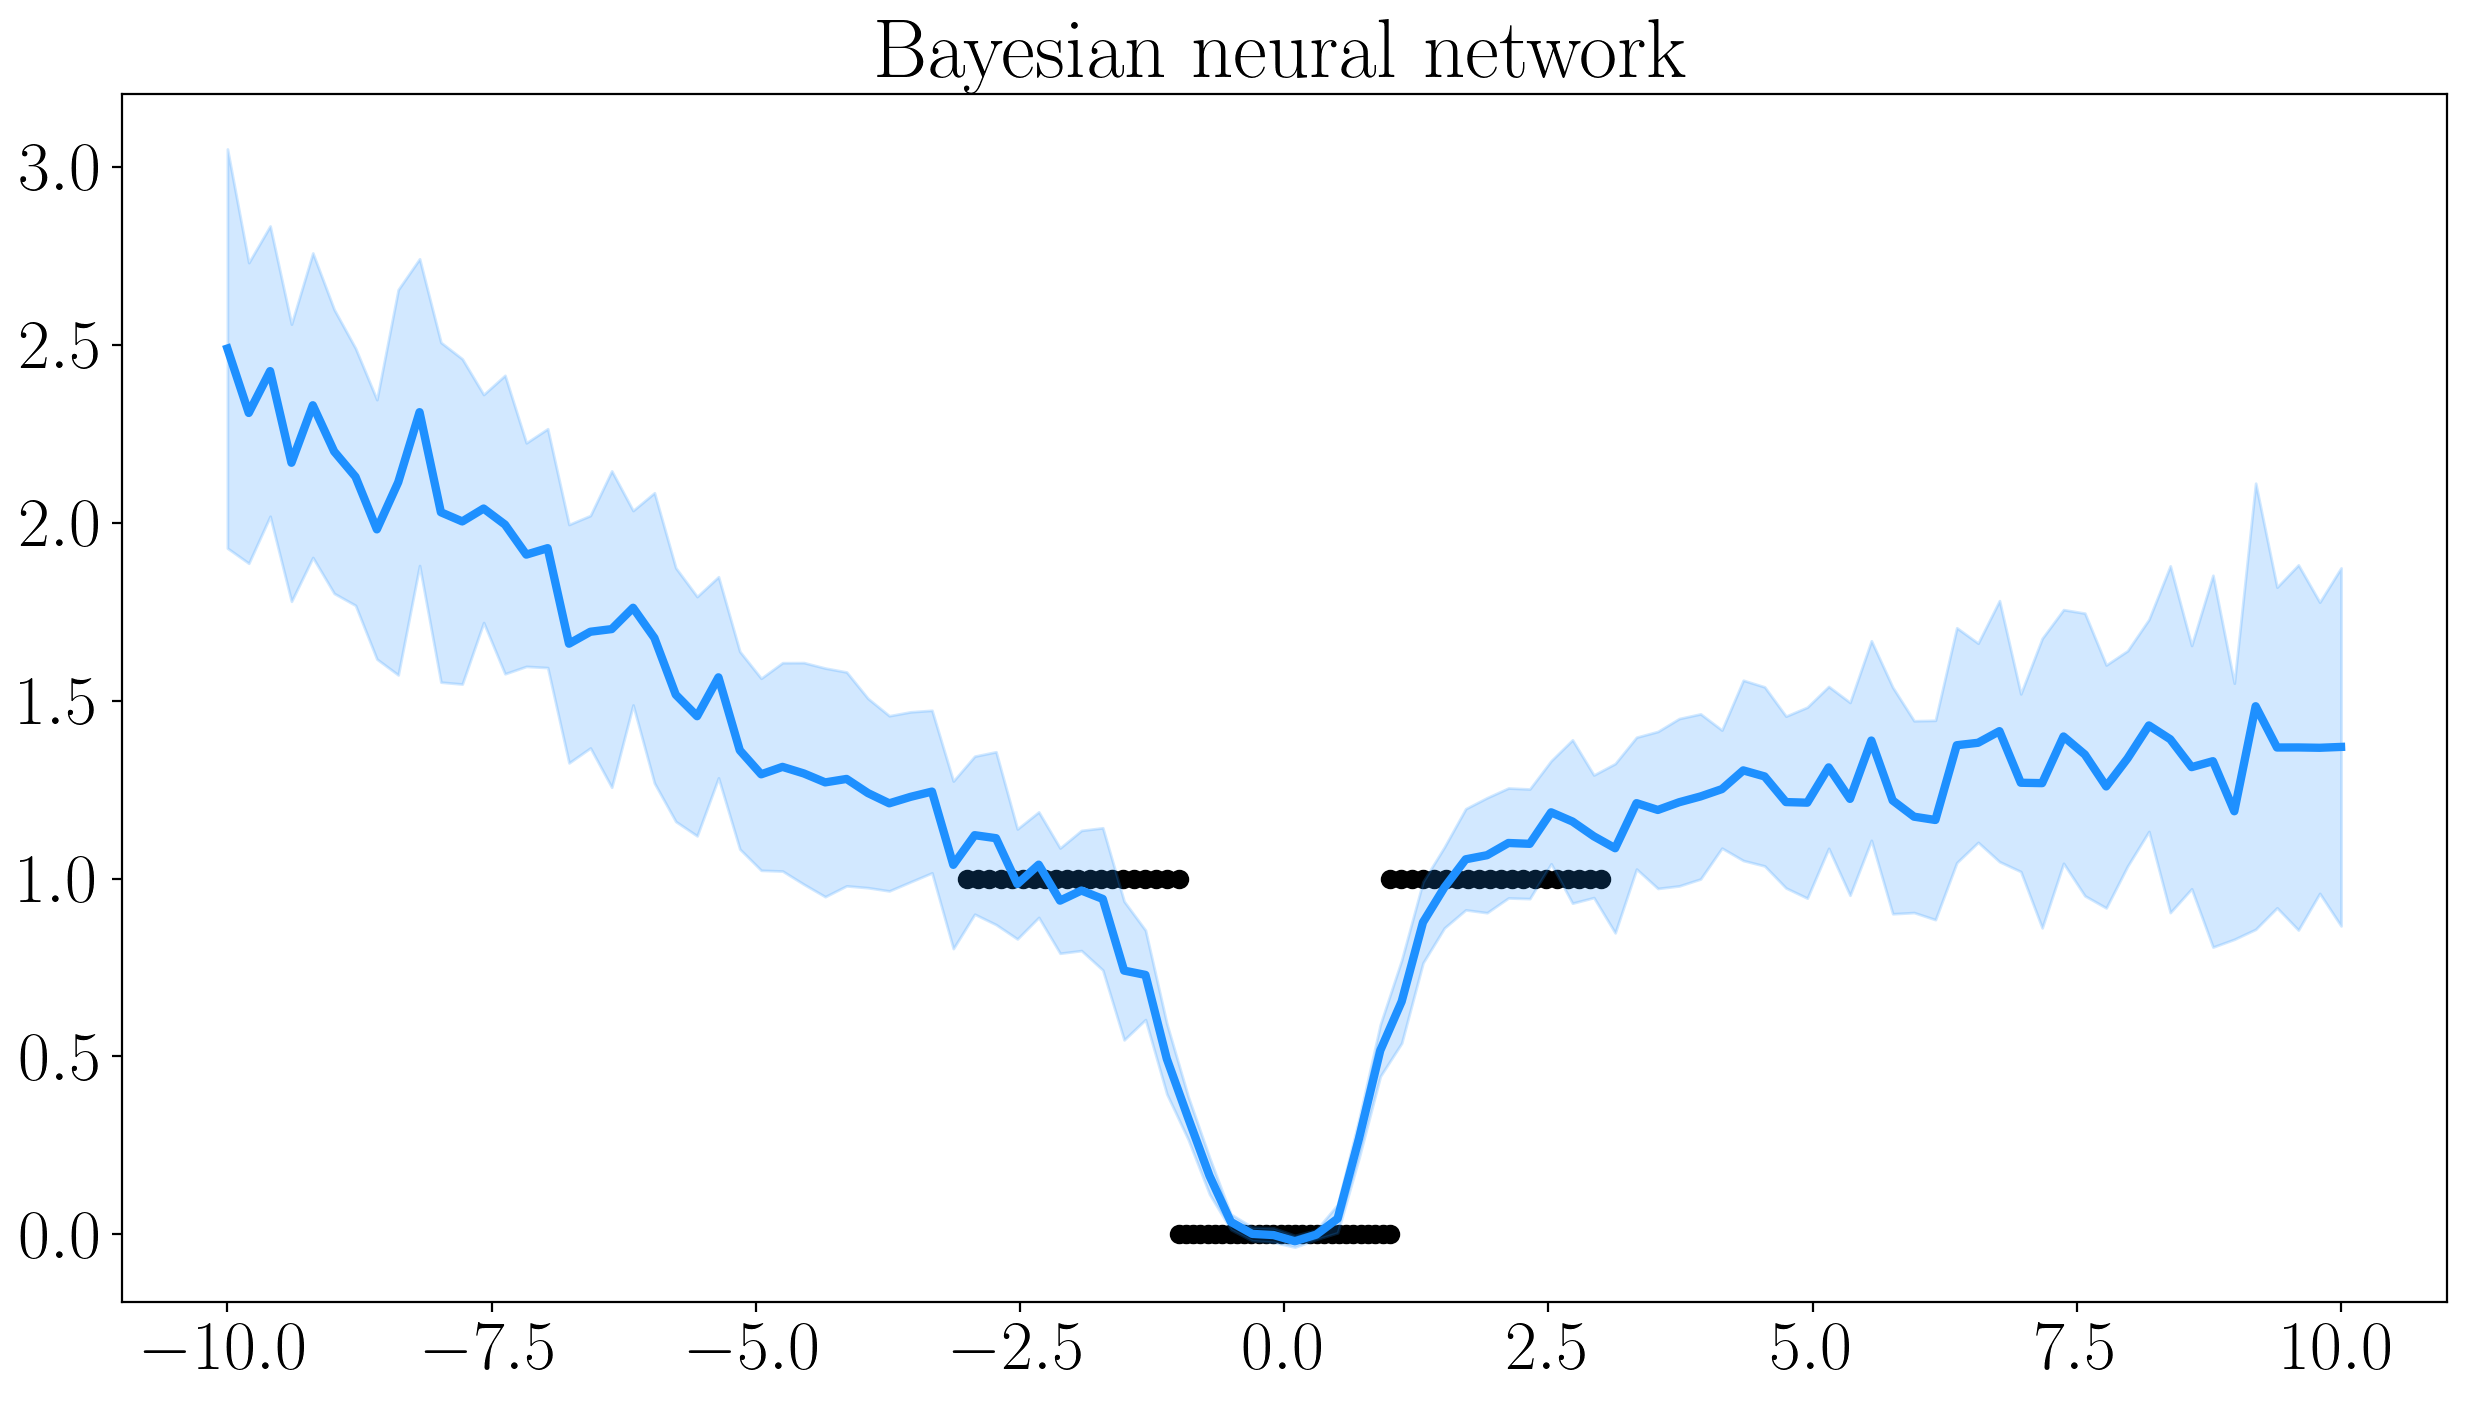

In [24]:
# Train the model
net = BayesNN(prior_std_init=0.05)

neg_elbo = NegativeELBO(net)

# Create the dataset
X, Y = get_dset1()
# plt.scatter(X, Y)

torch_dataset = Data.TensorDataset(X, Y)
BATCH_SIZE = 30
loader = Data.DataLoader(
    dataset=torch_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True, num_workers=2)

num_epochs = 100

loss_fn = torch.nn.MSELoss()
loss_hist = []
optim = torch.optim.Adam(params=net.parameters(), lr=2e-2)
stds_hist = []

for epoch in range(num_epochs):
    for i, (batch_x, batch_y) in enumerate(loader):  # for each training step
        loss = neg_elbo(batch_x, batch_y, 1e-5)
        loss_hist.append(loss.item())
        optim.zero_grad()
        loss.backward()
        optim.step()

    if epoch % 20 == 0:
        # Evaluate the model
        stds_hist.append(net.get_stds())
    print("Finished epoch Nr. ", epoch, "/", num_epochs)
        
fig = plt.figure(dpi=200)
fig.set_figheight(8)
fig.set_figwidth(15)
x = torch.linspace(-10, 10, 100)
n_samples = 20
results = torch.zeros([20, x.shape[0]])
for i in range(n_samples):
    X_eval = x.reshape(-1, 1)
    Y_pred = net(X_eval)
    results[i] = Y_pred.reshape(-1)
    # plt.plot(X_eval, Y_pred.detach().numpy())
plt.xticks(size=25)
plt.yticks(size=25)
plt.scatter(X, Y, c='k')
plt.plot(x.detach().numpy(), results.mean(dim=0).detach().numpy(),
         linewidth=3, c='dodgerblue')
plt.fill_between(x.detach().numpy(), 
                 results.mean(dim=0).detach().numpy() - results.std(dim=0).detach().numpy(), 
                 results.mean(dim=0).detach().numpy() + results.std(dim=0).detach().numpy(), 
                 color='dodgerblue', alpha=0.2)
plt.title("Bayesian neural network", size=30)
plt.savefig('figs/bnn_mean_std_02.pdf', bbox_inches='tight',pad_inches = 0.1, dpi = 200)

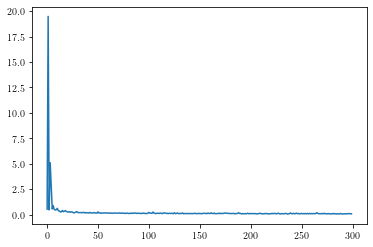

In [7]:
plt.plot(loss_hist)

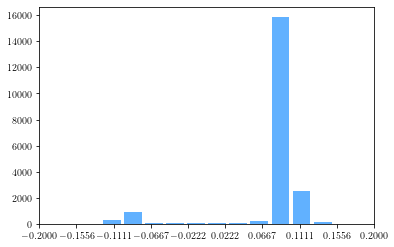

In [6]:
from utils.helper import HistGif
hg = HistGif()
hg.make_gif(data=np.swapaxes(np.array(stds_hist), 0, 1), nframes=5)


In [2]:
fig = plt.figure(dpi=200)
fig.set_figheight(8)
fig.set_figwidth(15)
x = torch.linspace(-10, 10, 100)
n_samples = 20
results = torch.zeros([20, x.shape[0]])
for i in range(n_samples):
    X_eval = x.reshape(-1, 1)
    Y_pred = net(X_eval)
    results[i] = Y_pred.reshape(-1)
    # plt.plot(X_eval, Y_pred.detach().numpy())
plt.xticks(size=25)
plt.yticks(size=25)
plt.scatter(X, Y, c='k')
plt.plot(x.detach().numpy(), results.mean(dim=0).detach().numpy(),
         linewidth=3, c='dodgerblue')
plt.fill_between(x.detach().numpy(), 
                 results.mean(dim=0).detach().numpy() - results.std(dim=0).detach().numpy(), 
                 results.mean(dim=0).detach().numpy() + results.std(dim=0).detach().numpy(), 
                 color='dodgerblue', alpha=0.2)
plt.title("Bayesian neural network", size=30)
plt.savefig('figs/bnn_mean_std.pdf', bbox_inches='tight',pad_inches = 0.1, dpi = 200)

NameError: name 'plt' is not defined

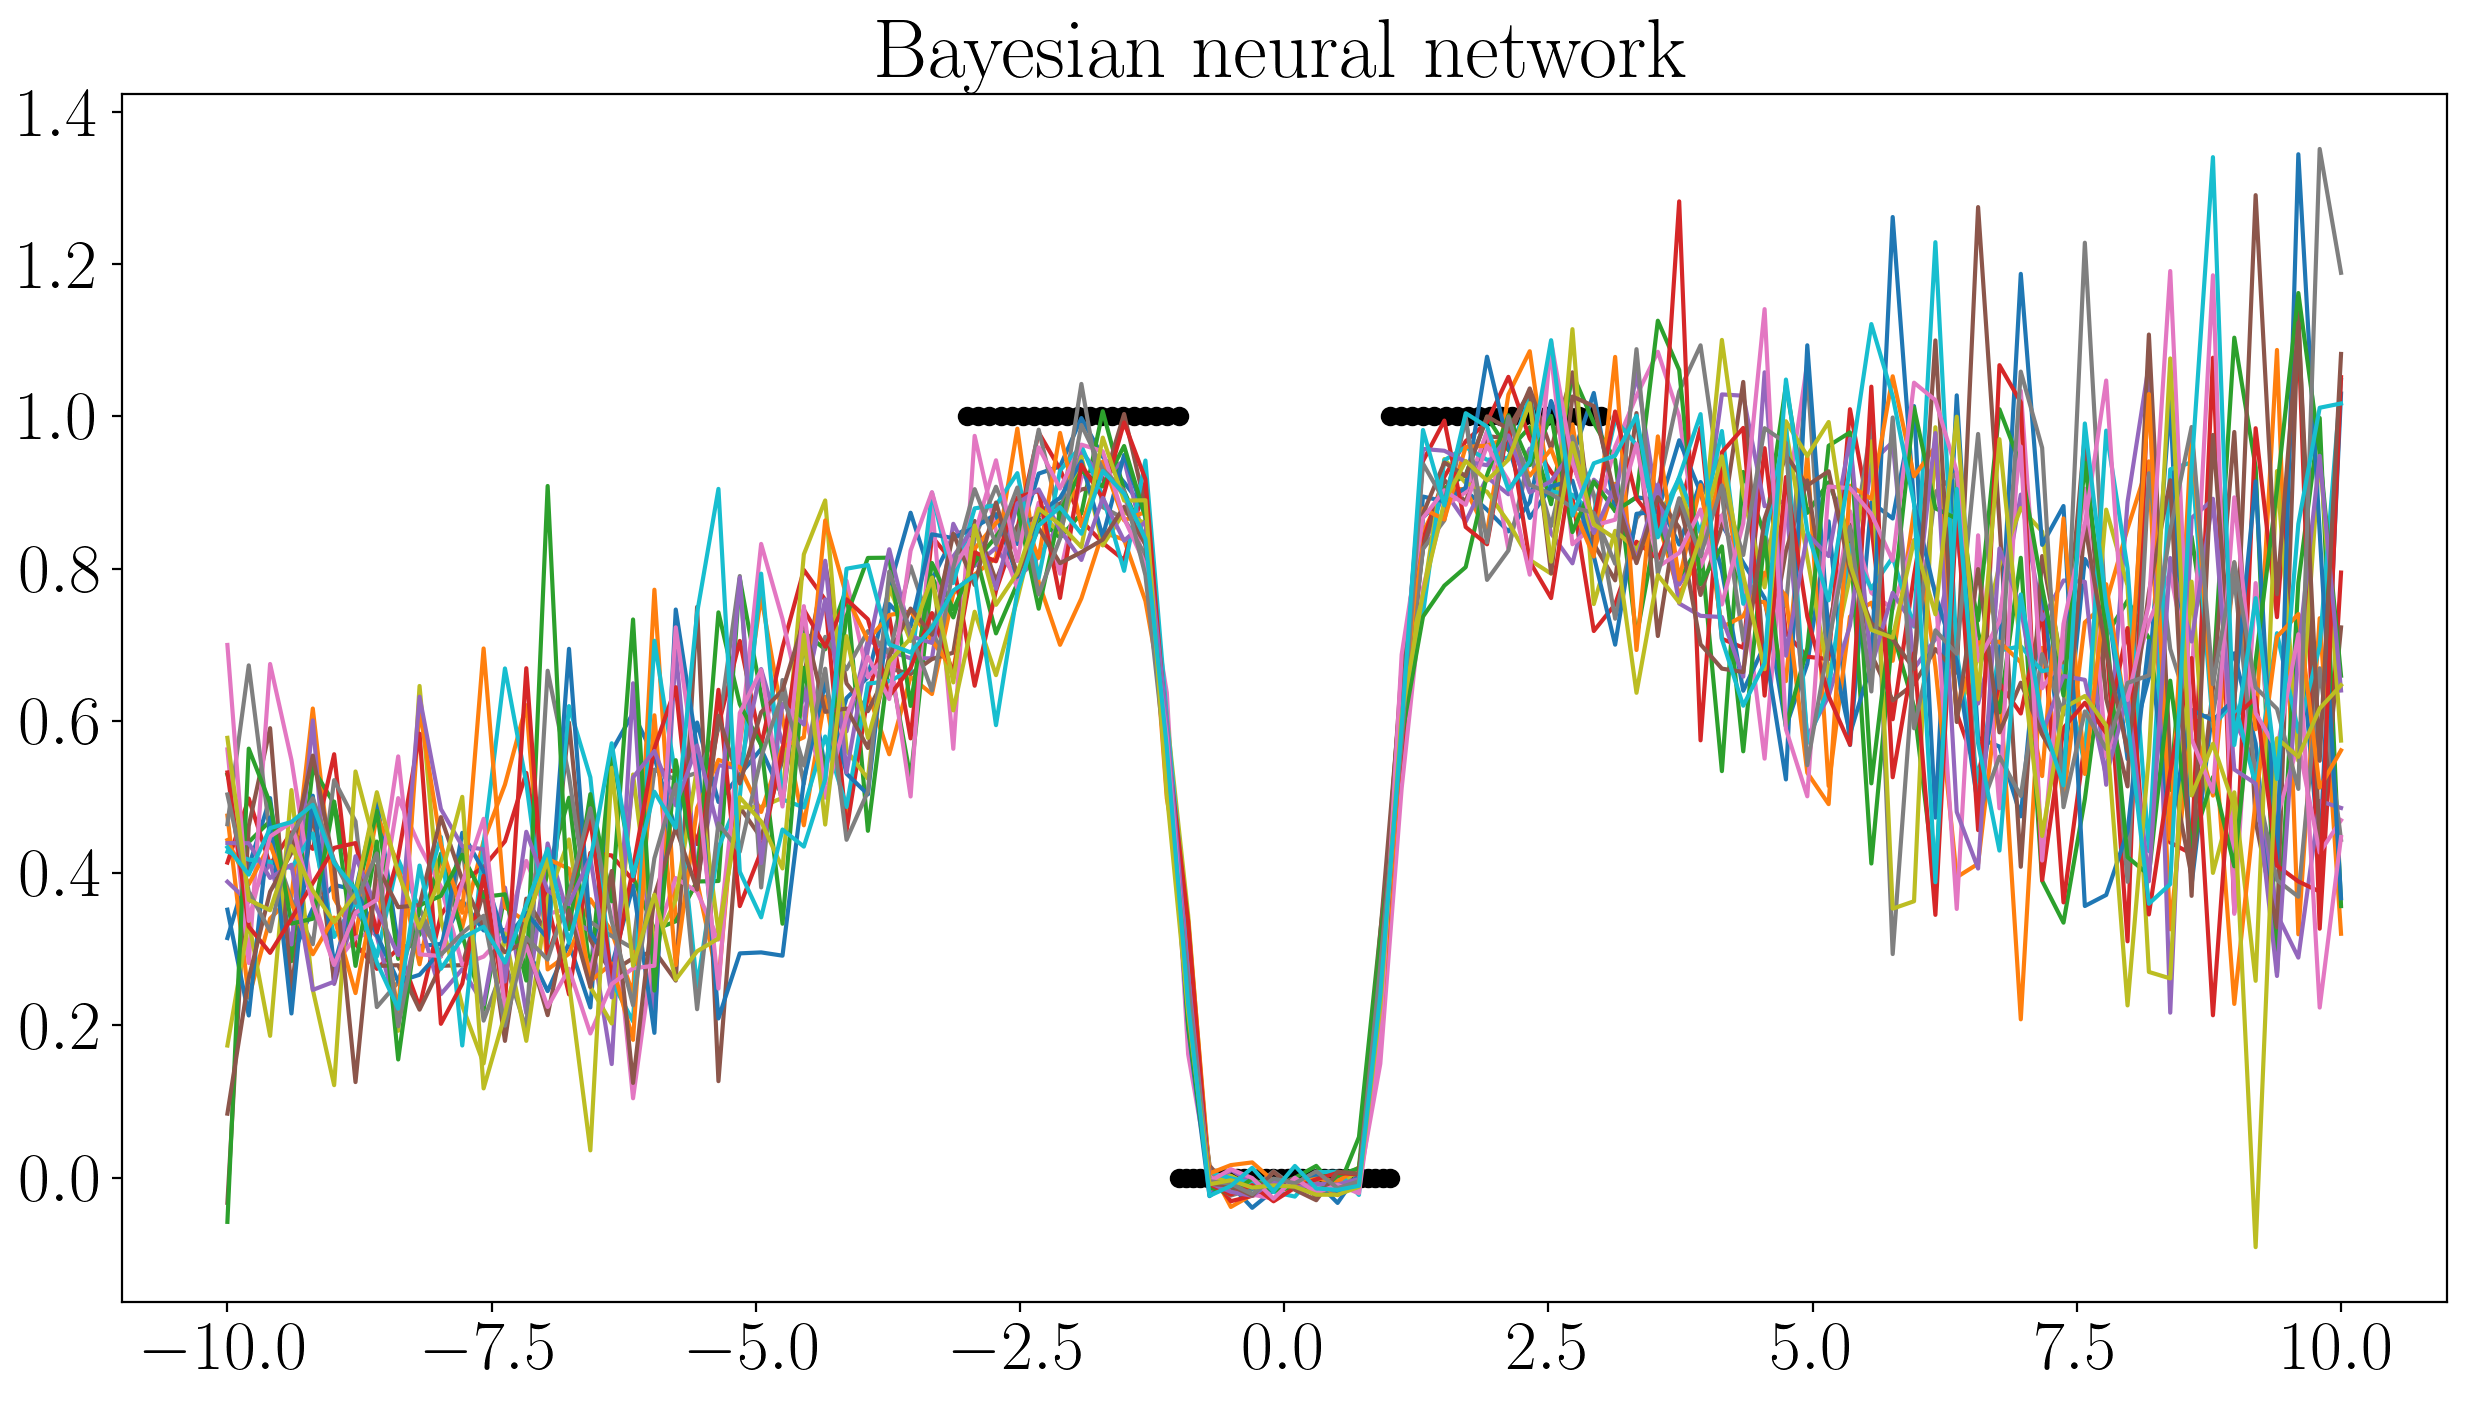

In [63]:
fig = plt.figure(dpi=200)
fig.set_figheight(8)
fig.set_figwidth(15)
x = torch.linspace(-10, 10, 100)
n_samples = 20
for i in range(n_samples):
    X_eval = x.reshape(-1, 1)
    Y_pred = net(X_eval)
    plt.plot(X_eval, Y_pred.detach().numpy())
plt.scatter(X, Y, c='k')
plt.xticks(size=25)
plt.yticks(size=25)
plt.title("Bayesian neural network", size=30)
plt.savefig('figs/bnn.pdf', bbox_inches='tight',pad_inches = 0.1, dpi = 200)

In [ ]:
# Conventional neural network
net = torch.nn.Sequential(
    torch.nn.Linear(1, 200),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(200, 100),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(100, 1),
)

# Create the dataset
X, Y = get_dset1()
plt.scatter(X, Y)

torch_dataset = Data.TensorDataset(X, Y)
BATCH_SIZE = 30
loader = Data.DataLoader(
    dataset=torch_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True, num_workers=2)

num_epochs = 100

loss_fn = torch.nn.MSELoss()
loss_hist = []
optim = torch.optim.Adam(params=net.parameters(), lr=2e-2)


for epoch in range(num_epochs):
    for i, (batch_x, batch_y) in enumerate(loader):  # for each training step
        # loss = neg_elbo(X, Y, 0)
        Y_pred = net(batch_x).reshape(-1, )
        assert Y_pred.shape == batch_y.shape, print(Y_pred.shape, batch_y.shape)
        loss = loss_fn(batch_y, Y_pred)
        loss_hist.append(loss.item())
        optim.zero_grad()
        loss.backward()
        optim.step()

    if epoch % 10 == 0:
        # Evaluate the model
        X_eval = torch.Tensor(np.linspace(-10, 10, 100)).reshape(-1, 1)
        Y_pred = net(X_eval)
        plt.scatter(X, Y)
        plt.plot(X_eval, Y_pred.detach().numpy())
        plt.show()

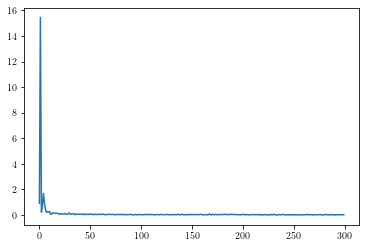

In [65]:
plt.plot(loss_hist)

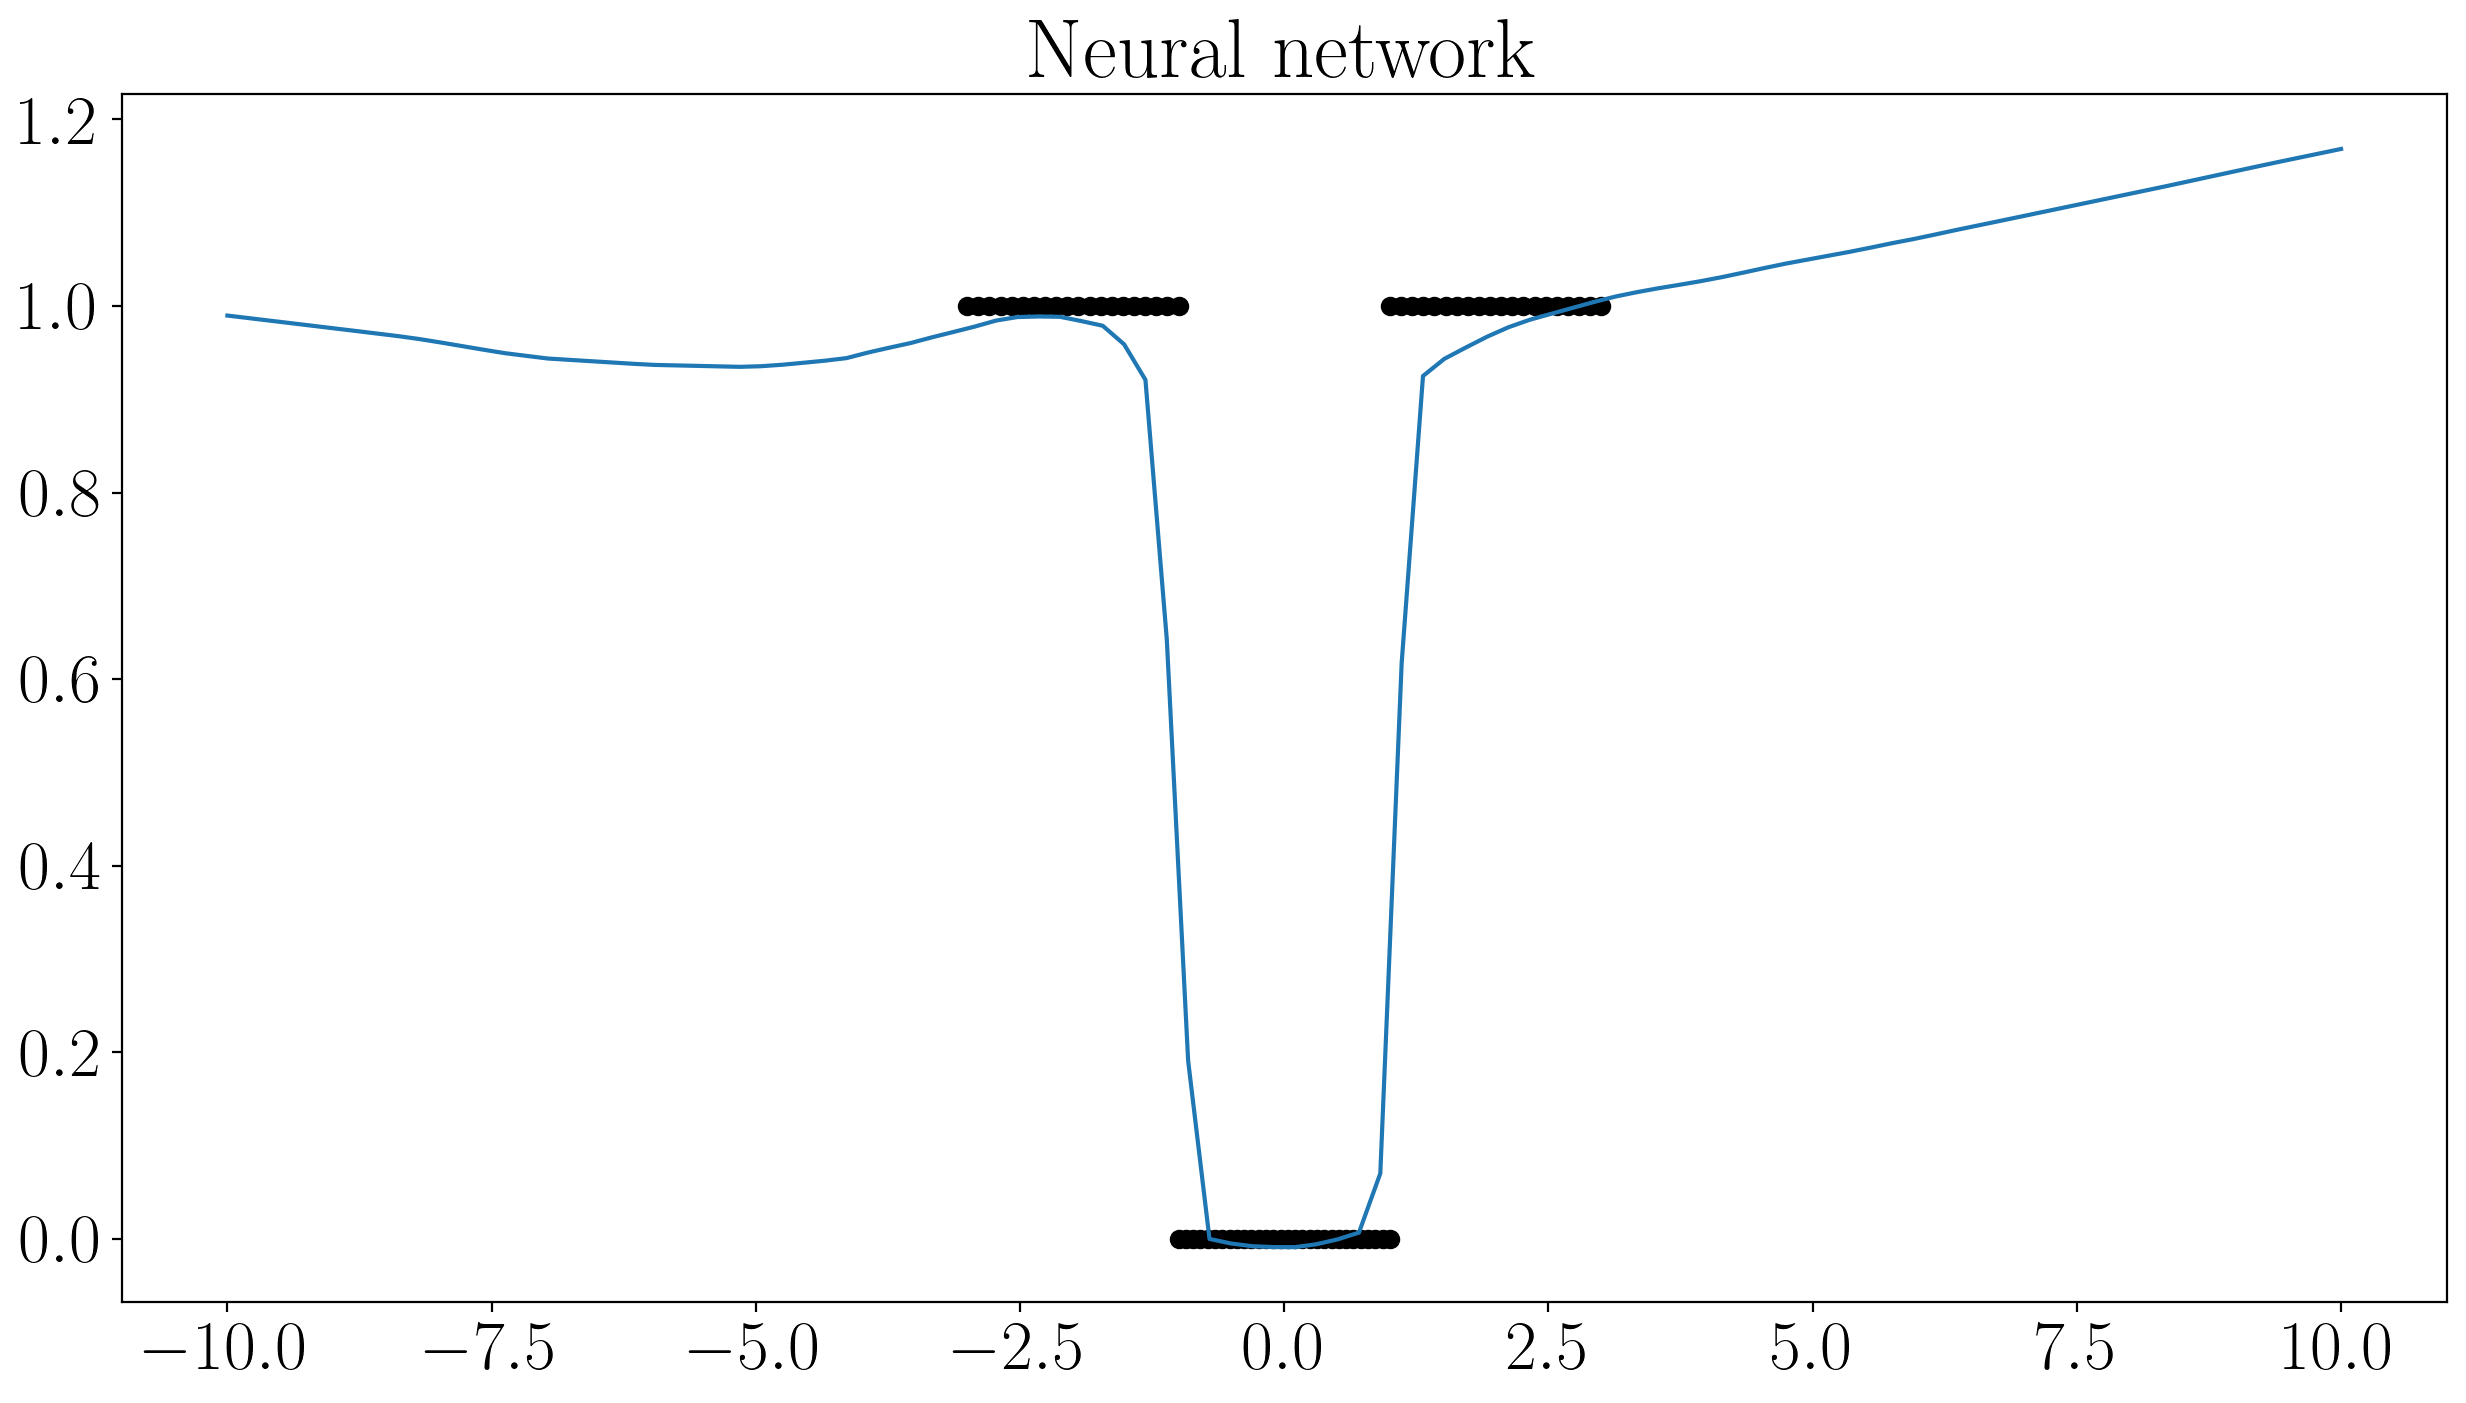

In [66]:
fig = plt.figure(dpi=200)
fig.set_figheight(8)
fig.set_figwidth(15)

X_eval = torch.Tensor(np.linspace(-10, 10, 100)).reshape(-1, 1)
Y_pred = net(X_eval)
plt.plot(X_eval, Y_pred.detach().numpy())
plt.scatter(X, Y, c='k')
plt.xticks(size=25)
plt.yticks(size=25)
plt.plot()
plt.title("Neural network", size=30)
plt.savefig('figs/nn.pdf', bbox_inches='tight',pad_inches = 0.1, dpi = 200)
